This was a short exercise to try to predict number of appliances from a set of energy-related features, along with doing some analysis to better understand the data and for preprocessing purposes.

### Initial observations:
- No features are highly correlated with, or have obviously high predictive power (by themselves), for Appliances.
- There are some outliers:
   - Very few values of lights are above 40. Only 1 is 60 and 1 is 70. These are probably the most significant
     outliers.
   - 2 values for Appliances are quite a bit greater than the others.
   - One or two other values stand out a bit above the others.

  Depending on the model used, this might warrant some action to avoid having a model draw conclusions for a specific
  interval based on very few data points and having these heavily affect the classification. The outliers could be
  excluded from training or we could use non-linear normalisation. But none of these outliers are too extreme.
- Some values have occasional negative values (which may be a sign of data problems), but those appear to be valid.
  Based on the range of values and the energy trading domain, I expect those are temperatures in degrees Celsius.
- The lights values are only multiples of 10, but this shouldn't really be a problem for the most part.
- Windspeed and Visibility have suspiciously many of specific values.
  - A disproportionate amount of the Windspeed values are round numbers, and fractions 
 with 6 in the denominator are also more common than other values. This may mean these were recorded or processed in a
 different way from the others, but I don't foresee this causing too much a problem if this is just rounding fractions.
  - A large portion of the Visibility values are exactly 40, which is quite suspect. This might indicate a problem with
 the data and could warrant some further investigation.
 
    It appears to be distributed across the entire time period (meaning it's just not a short-term fault) and it doesn't
 appear to be tied to specific times of the day. If we just look at a specific day, this also features questionable
 perfect spikes, which seems like it might be the result of only getting values on an hourly basis and filling in the
 blanks in a straight line. Using this feature as is could be a problem for prediction, because in production we won't
 have the future values to determine what the current values are. Forward filling would make more sense.
 
    For the purposes of this task, I'll just leave this as is.

### Notes about correlations:
- For the correlations between the individual TX and RH_X values, the only ones with a reasonably strong correlation
  are T6 and RH_6, with a correlation of -0.67.
- Temperatures and humidities are both highly correlated with other temperatures and humidities. It would probably
  make sense to split these into components using PCA or to only include one or a subset of each if we want to use
  these as features.
- rv1 and rv2 are identical and one should be dropped.
- There aren't strong correlations across any of the other values.

### Trends analysis
There seems to be some clear daily/weekly trends, with barely any appliances in the early morning hours, peak
 appliances in the early evening and some variation between weekdays.

Monthly trends and yearly seasonal trends could also exist, although the time period of the data provided is a bit
 short to say too much about this. There doesn't seem to be too strong trends like these within those 5 months.

### Model training and performance
I used a Random Forest Regressor, which is a fairly solid model for moderately-sized data sets, and I used mean square distance as an evaluation metric.
 The actual best metric would heavily depend on the business cost (expected immediate financial loss, reputation changes, etc.) from making inaccurate predictions.
 I used the first 4 months as training data and the last month as test data, which is a reasonably-sized 80:20 split,
 it puts the test data timewise after the training set, which matches what would happen in production, and it gives us a full month to evaluate.

As I baseline model I simply used the Appliances value immediately before the current one as the predicted value.
 My initial model uses a few of the most recent Appliances values, which provides quite a lot of predictive power and significantly improves on the baseline.
 I also tried a model just based on date and time features, which didn't perform very well.
 Combining recent values with date and time features improves a bit on the model with only recent values and including the lights feature improves on this a bit more.
 These improvements aren't that substantial though and don't show up on every run, which makes them somewhat questionable as improvements.
 None of the other exogenous variables (individually or by themselves) seem to help much with prediction, although some feature engineering might change that.

The above assumes we want to predict only 10 minutes in advance, which certainly may not always be the case.
 If we want to do future trades and, say, predict 1 day or more in advance, we can expect the performance to decrease quite a bit.
 I included a model to show what we might expect in such a case, using the best model from a few I tried. It is indeed quite a bit worse than using recent values.

Next steps might include trying other model types and tuning hyperparameters using a cross-validation set.


In [ ]:
import datetime as dt

from IPython.core import display as ICD
import numpy as np
import pandas as pd

df = pd.read_csv('data/energy-data.csv', parse_dates=[0])
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [ ]:
na_counts = df.isna().sum()
print("Columns with missing data:")
na_counts[na_counts.apply(lambda x: x > 0)]

Columns with missing data:


Series([], dtype: int64)

Features with > 0.1 (positive or negative) correlation with Appliances:
   lights: 0.197
   T2: 0.120
   T6: 0.118
   RH_out: -0.152


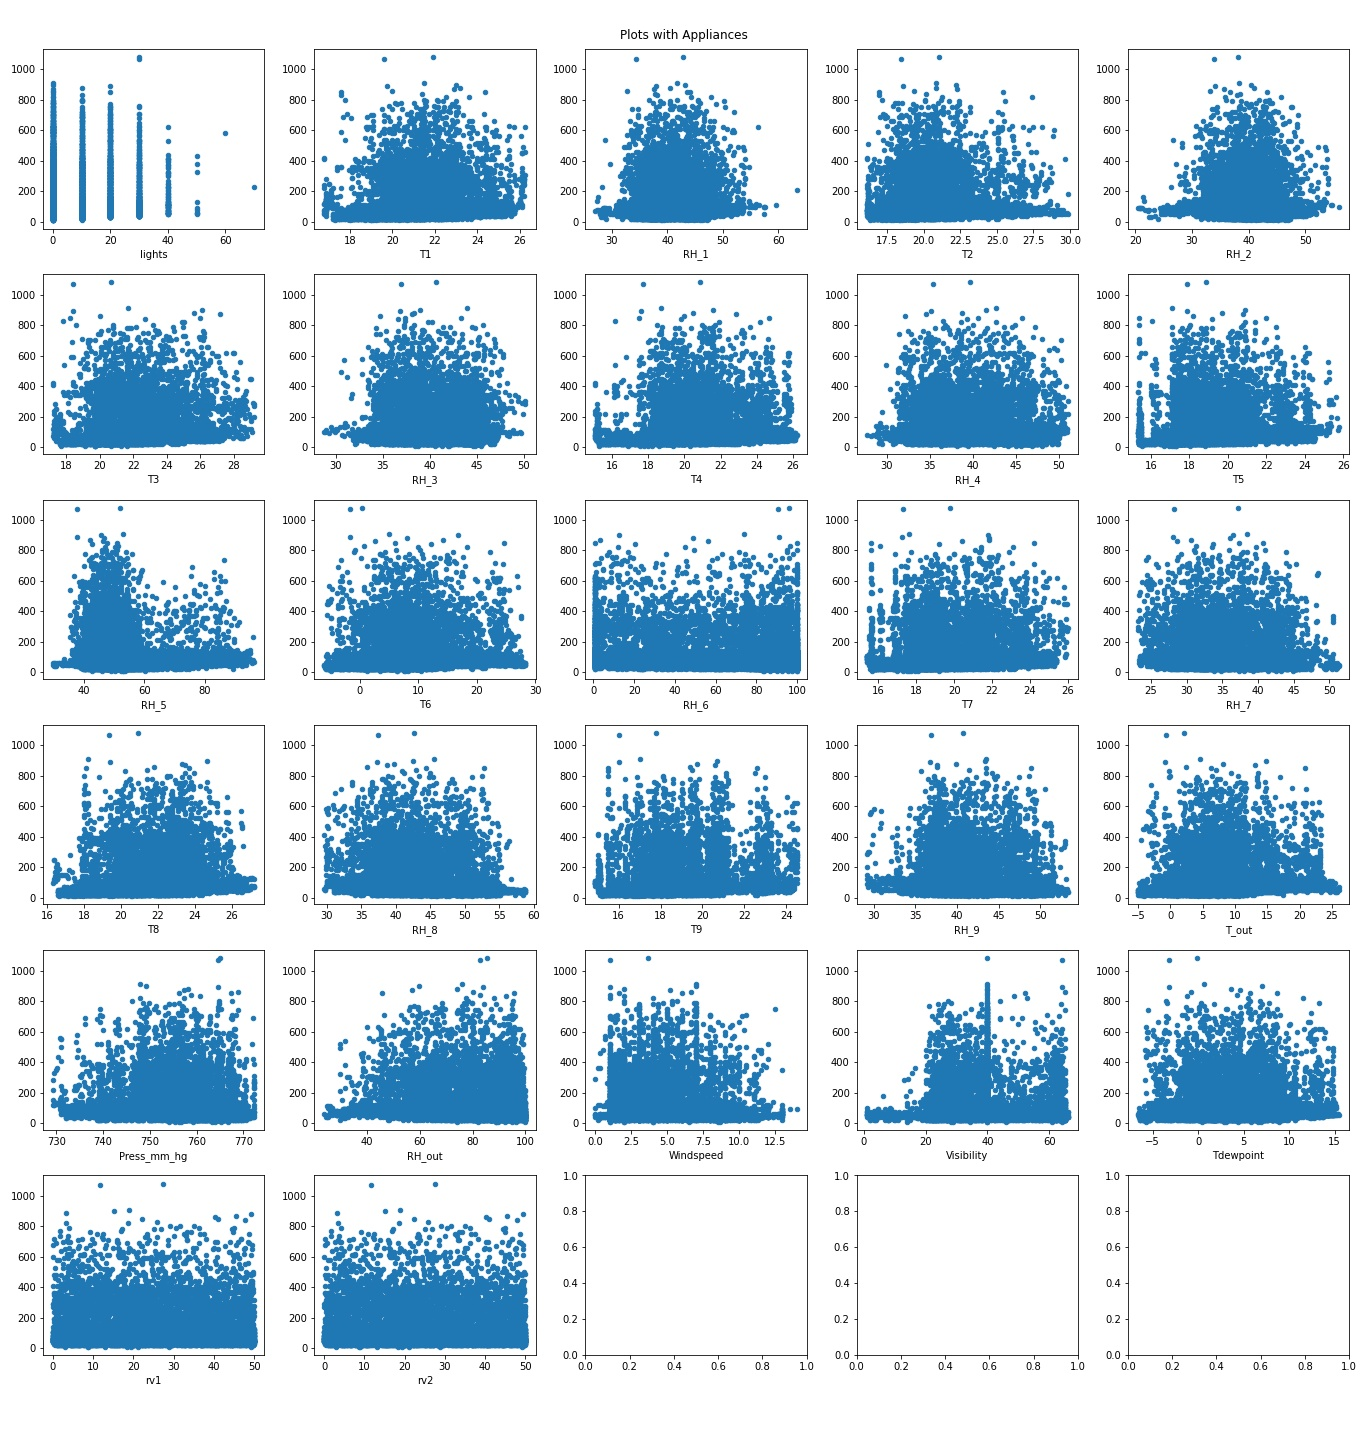

<Figure size 1368x1440 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tempfile import TemporaryFile

# Reduce notebook file size by outputting an image instead of a plot
def display_plot_as_image():
    with TemporaryFile(suffix='.jpg') as tmp_file:
        plt.gcf().savefig(tmp_file, format='jpg')
        plt.clf()
        tmp_file.seek(0)
        ICD.display(ICD.Image(data=tmp_file.read()))

features = [col for col in df.columns if col not in ('date', 'Appliances')]

print("Features with > 0.1 (positive or negative) correlation with Appliances:")
for feature in features:
    if abs(pearsonr(df['Appliances'], df[feature])[0]) > 0.1:
        print(f"   {feature}: {pearsonr(df['Appliances'], df[feature])[0]:.3f}")

# 27 features with 5 columns requires 6 rows
cols, rows = 5, 6
subplots = [(x, y) for y in range(rows) for x in range(cols)]
fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=(19, 20))
fig.suptitle("Plots with Appliances")

for i, column in enumerate(features):
    ax = df.plot.scatter(x=column, y='Appliances', ax=axis[subplots[i][1], subplots[i][0]])
    ax.set_ylabel("")

fig.tight_layout(rect=[0, 0.03, 1, 0.99])

display_plot_as_image()

In [ ]:
df['Windspeed'].apply(lambda x: f"{x - int(x):.5f}"[1:]).value_counts().head(10)

.00000    10938
.33333     2132
.66667     2132
.50000     1621
.83333     1396
.16667     1396
.42857        6
.57143        6
.28571        6
.71429        6
Name: Windspeed, dtype: int64

Total count: 19735
40.000000    7224
29.000000     449
36.333333     257
23.000000     247
28.000000     245
             ... 
33.277778       1
35.722222       1
61.916667       1
2.500000        1
32.361111       1
Name: Visibility, Length: 413, dtype: int64


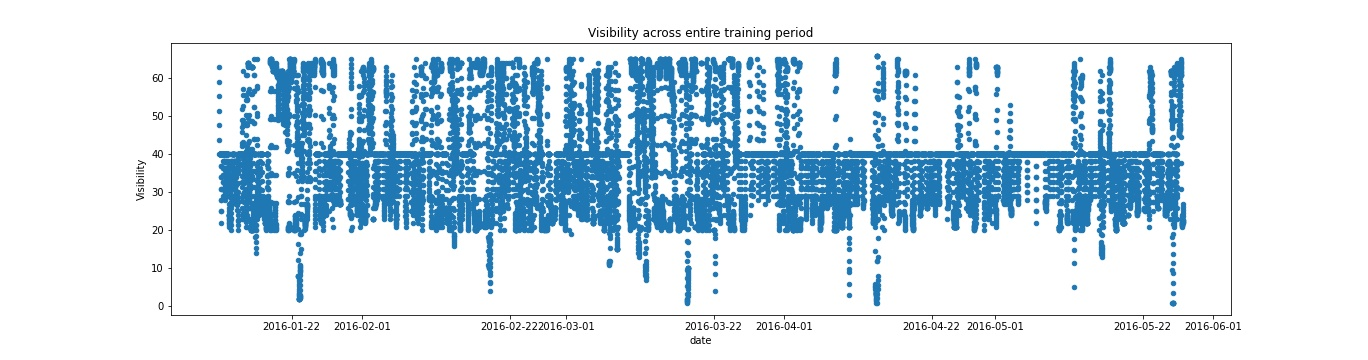

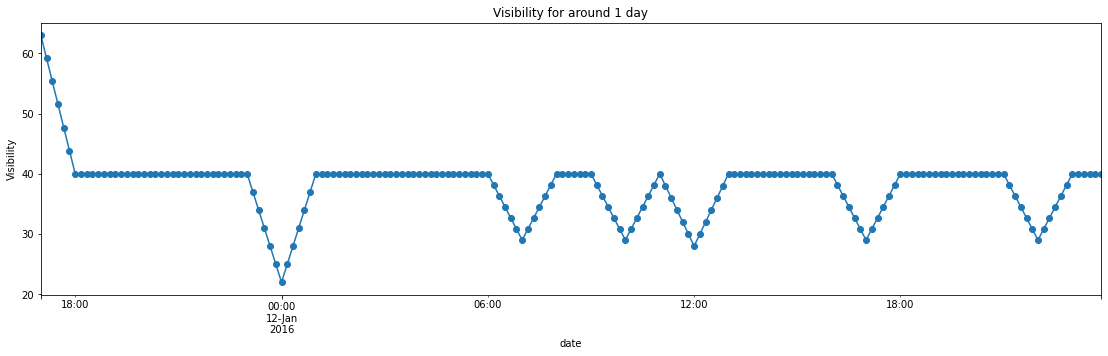

In [ ]:
print("Total count:", df['Visibility'].count())
print(df['Visibility'].value_counts())

df.plot.scatter(x='date', y='Visibility', figsize=(19, 5), title="Visibility across entire training period")
display_plot_as_image()

df[df['date'] < '2016-01-13'].set_index('date')['Visibility'].plot(ylabel="Visibility", title="Visibility for around 1 day", marker='o')

pass

In [ ]:
import re

def display_correlation(df, triangle=True, calculate_corr=True):
    corr_df = df.corr() if calculate_corr else df
    if triangle:
        mask = np.zeros_like(corr_df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr_df[mask] = np.nan
    ICD.display(corr_df
        .style
        .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
        .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
        .set_precision(2))

display_correlation(pd.DataFrame([{"column 1": f'T{i}', "column 2": f'RH_{i}', "correlation": pearsonr(df[f'T{i}'], df[f'RH_{i}'])[0]}
                                  for i in range(1, 10)]), triangle=False, calculate_corr=False)

display_correlation(df[[f for f in features if f.startswith('T')]])

display_correlation(df[[f for f in features if f.startswith('RH')]])

display_correlation(df[[f for f in features if not re.match("(T|RH_)(?!1).*", f)]])

plt.show()

print("Number of different values between rv1 and rv2:", (df['rv1'] != df['rv2']).sum())

,column 1,column 2,correlation
0,T1,RH_1,0.16
1,T2,RH_2,-0.17
2,T3,RH_3,-0.01
3,T4,RH_4,-0.05
4,T5,RH_5,0.03
5,T6,RH_6,-0.67
6,T7,RH_7,-0.03
7,T8,RH_8,-0.21
8,T9,RH_9,-0.01


,T1,T2,T3,T4,T5,T6,T7,T8,T9,T_out,Tdewpoint
T1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T2,0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T3,0.89,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan
T4,0.88,0.76,0.85,nan,nan,nan,nan,nan,nan,nan,nan
T5,0.89,0.72,0.89,0.87,nan,nan,nan,nan,nan,nan,nan
T6,0.65,0.80,0.69,0.65,0.63,nan,nan,nan,nan,nan,nan
T7,0.84,0.66,0.85,0.88,0.87,0.62,nan,nan,nan,nan,nan
T8,0.83,0.58,0.80,0.80,0.82,0.48,0.88,nan,nan,nan,nan
T9,0.84,0.68,0.90,0.89,0.91,0.67,0.94,0.87,nan,nan,nan
T_out,0.68,0.79,0.70,0.66,0.65,0.97,0.63,0.50,0.67,nan,nan


,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out
RH_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
RH_2,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan
RH_3,0.84,0.68,nan,nan,nan,nan,nan,nan,nan,nan
RH_4,0.88,0.72,0.90,nan,nan,nan,nan,nan,nan,nan
RH_5,0.30,0.25,0.38,0.35,nan,nan,nan,nan,nan,nan
RH_6,0.25,0.39,0.51,0.39,0.26,nan,nan,nan,nan,nan
RH_7,0.80,0.69,0.83,0.89,0.33,0.36,nan,nan,nan,nan
RH_8,0.74,0.68,0.83,0.85,0.36,0.49,0.88,nan,nan,nan
RH_9,0.76,0.68,0.83,0.86,0.27,0.39,0.86,0.86,nan,nan
RH_out,0.27,0.58,0.36,0.34,0.19,0.72,0.38,0.49,0.36,nan


,lights,T1,RH_1,Press_mm_hg,Windspeed,Visibility,rv1,rv2
lights,nan,nan,nan,nan,nan,nan,nan,nan
T1,-0.02,nan,nan,nan,nan,nan,nan,nan
RH_1,0.11,0.16,nan,nan,nan,nan,nan,nan
Press_mm_hg,-0.01,-0.15,-0.29,nan,nan,nan,nan,nan
Windspeed,0.06,-0.09,0.20,-0.24,nan,nan,nan,nan
Visibility,0.02,-0.08,-0.02,0.04,-0.01,nan,nan,nan
rv1,0.00,-0.01,-0.00,0.00,-0.01,-0.01,nan,nan
rv2,0.00,-0.01,-0.00,0.00,-0.01,-0.01,1.00,nan


Number of different values between rv1 and rv2: 0


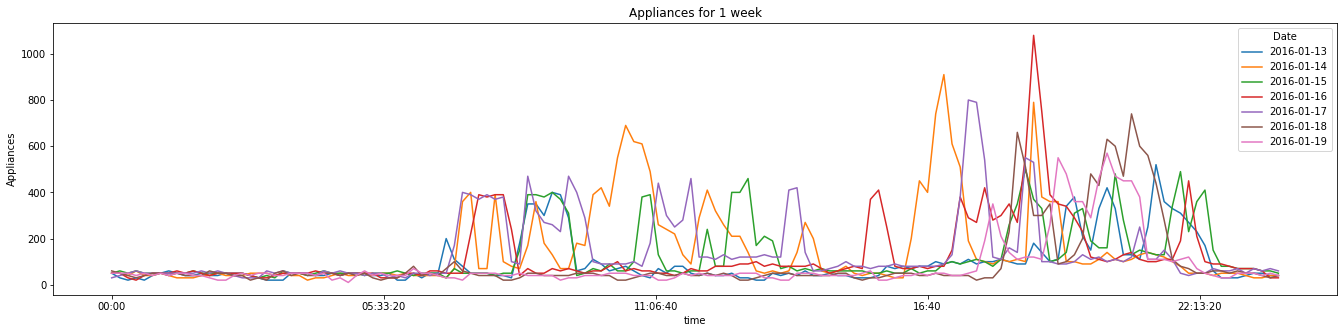

<Figure size 432x288 with 0 Axes>

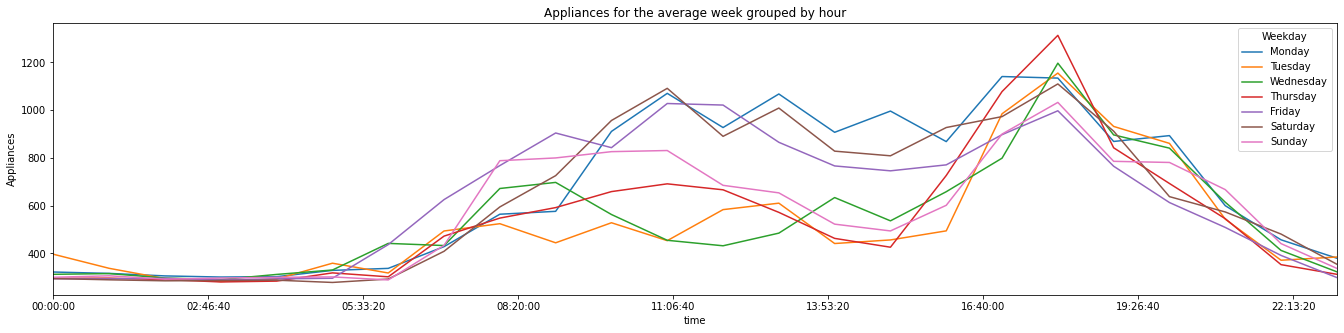

<Figure size 432x288 with 0 Axes>

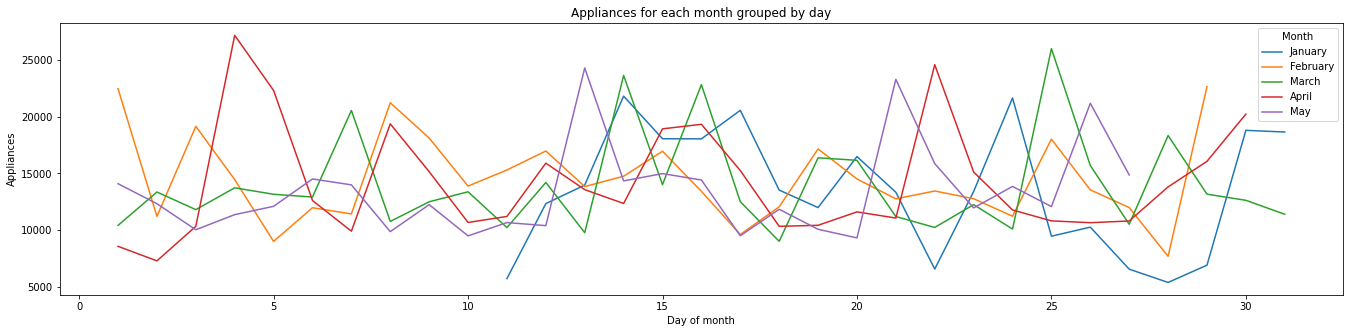

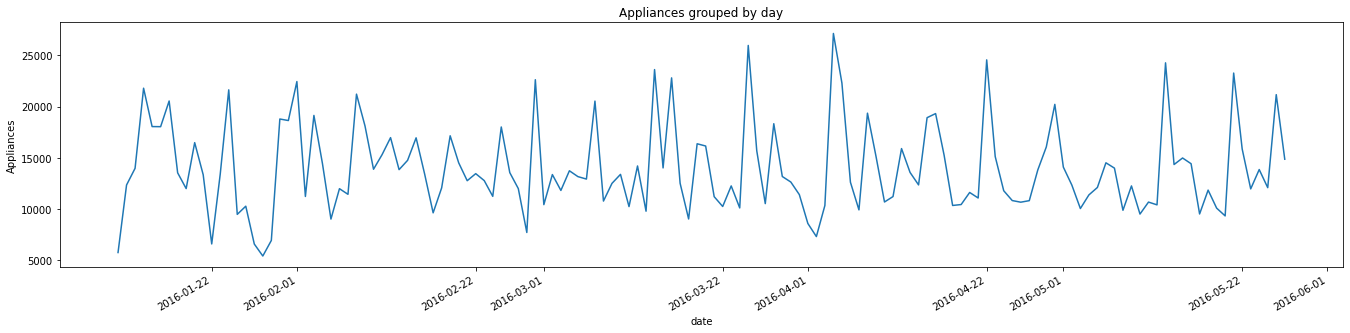

In [ ]:
import calendar

plot_title = "Appliances for 1 week"
df_tmp = df[['date', 'Appliances']].copy()
df_tmp['time'] = df_tmp['date'].apply(lambda x: x.time())
df_tmp['Date'] = df_tmp['date'].apply(lambda x: str(x.date()))
df_tmp = df_tmp[(df_tmp['date'].dt.date >= pd.to_datetime('2016-01-13')) & (df_tmp['date'].dt.date < pd.to_datetime('2016-01-20'))]
df_tmp = df_tmp.set_index(['time', 'Date'])['Appliances'].unstack()
df_tmp.plot(figsize=(23, 5), ylabel="Appliances", title=plot_title)
plt.figure()

plot_title = "Appliances for the average week grouped by hour"
earliest_monday = pd.to_datetime(df['date'].min().date() - pd.Timedelta(days=dt.date.weekday(df['date'].min().date())))
df_tmp = df[['date', 'Appliances']].copy()
df_tmp['date'] = df_tmp['date'].apply(lambda x: x - pd.Timedelta(minutes=x.minute))
df_tmp = df_tmp.groupby('date', as_index=False).sum()
df_tmp['date'] = (df_tmp['date'] - earliest_monday) % pd.Timedelta(days=7)
df_tmp = df_tmp.groupby('date', as_index=False).mean()
df_tmp['time'] = df_tmp['date'].dt.seconds.apply(lambda x: pd.Timedelta(seconds=x))
df_tmp['Weekday'] = df_tmp['date'] - df_tmp['time']
df_tmp = df_tmp.set_index(['time', 'Weekday'])['Appliances'].unstack()
df_tmp = df_tmp.rename(columns=lambda x: calendar.day_name[x.days])
df_tmp.plot(figsize=(23, 5), ylabel="Appliances", title=plot_title)
plt.figure()

plot_title = "Appliances for each month grouped by day"
df_tmp = df[['date', 'Appliances']].copy()
df_tmp['date'] = pd.to_datetime(df_tmp['date'].dt.date)
df_tmp = df_tmp.groupby('date', as_index=False).sum()
df_tmp['Day of month'] = df_tmp['date'].dt.day
df_tmp['Month'] = df_tmp['date'].apply(lambda x: x.month)
df_tmp = df_tmp.set_index(['Day of month', 'Month'])['Appliances'].unstack()
df_tmp = df_tmp.rename(columns=lambda x: calendar.month_name[x])
df_tmp.plot(figsize=(23, 5), ylabel="Appliances", title=plot_title)
plt.figure()

plot_title = "Appliances grouped by day"
df_tmp = df[['date', 'Appliances']].copy()
df_tmp['date'] = df_tmp['date'].dt.date
df_tmp.groupby('date').sum()['Appliances'].plot(figsize=(23, 5), ylabel="Appliances", title=plot_title)
plt.gcf().autofmt_xdate()

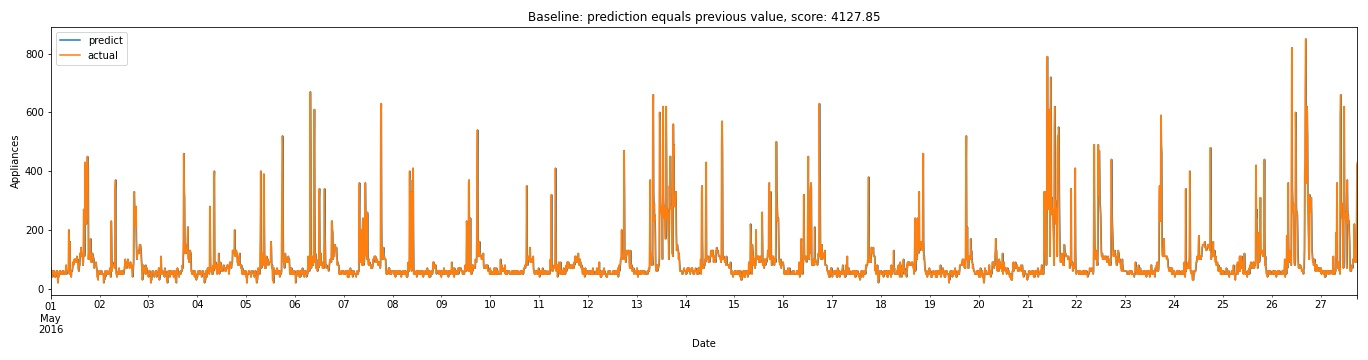

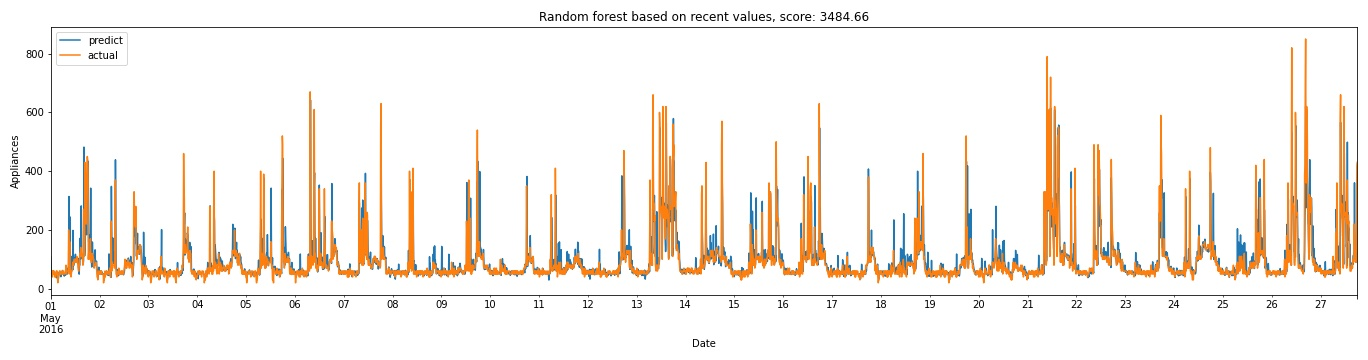

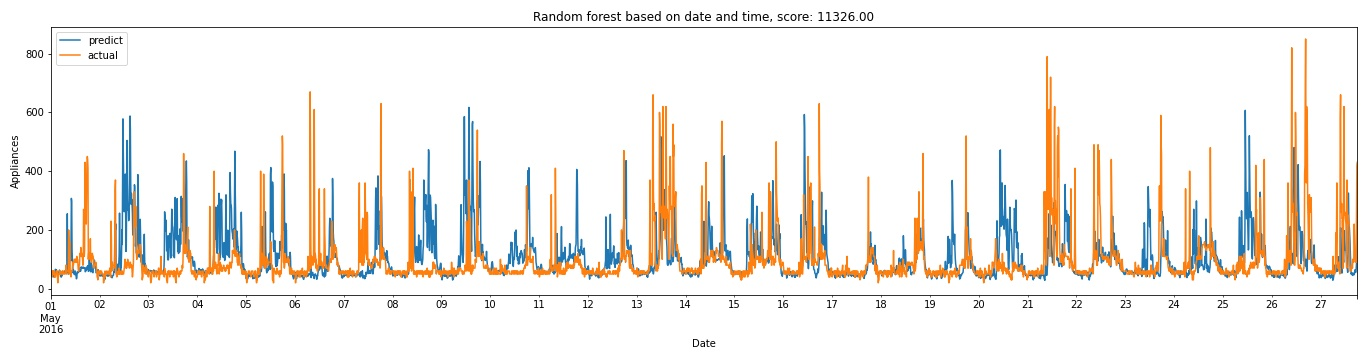

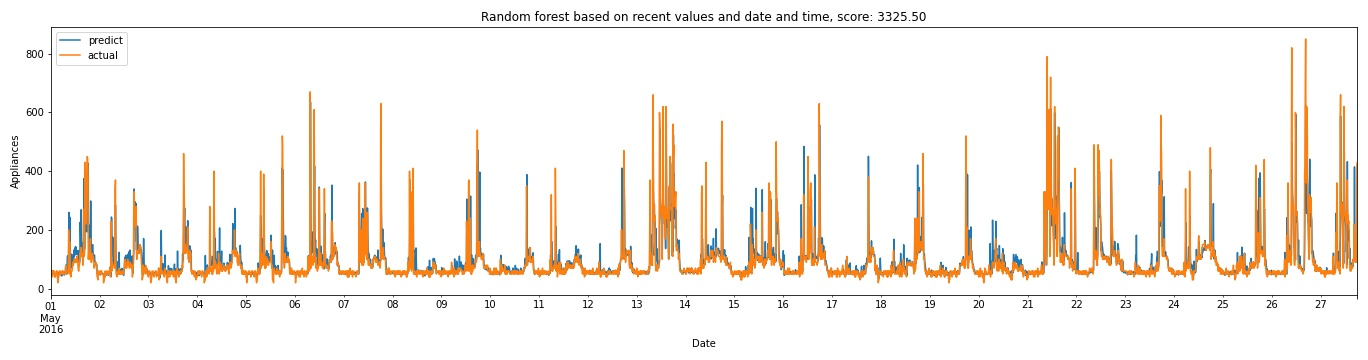

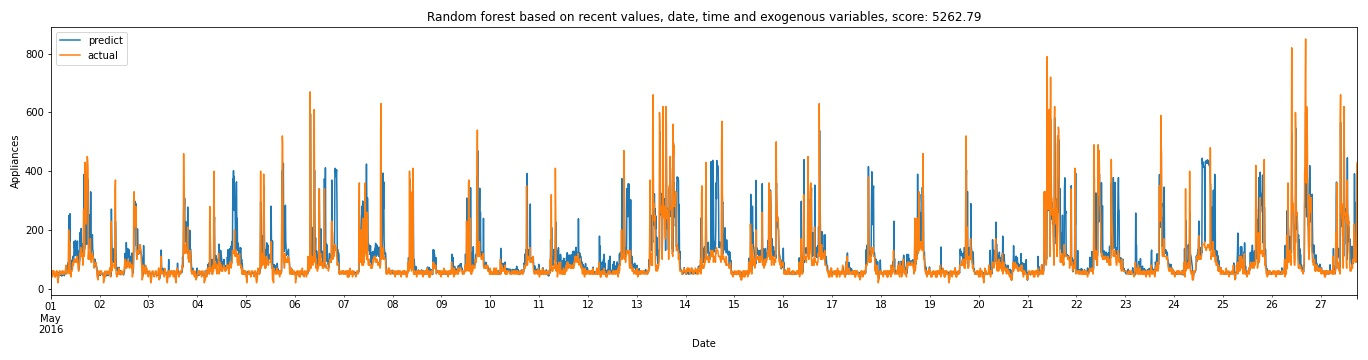

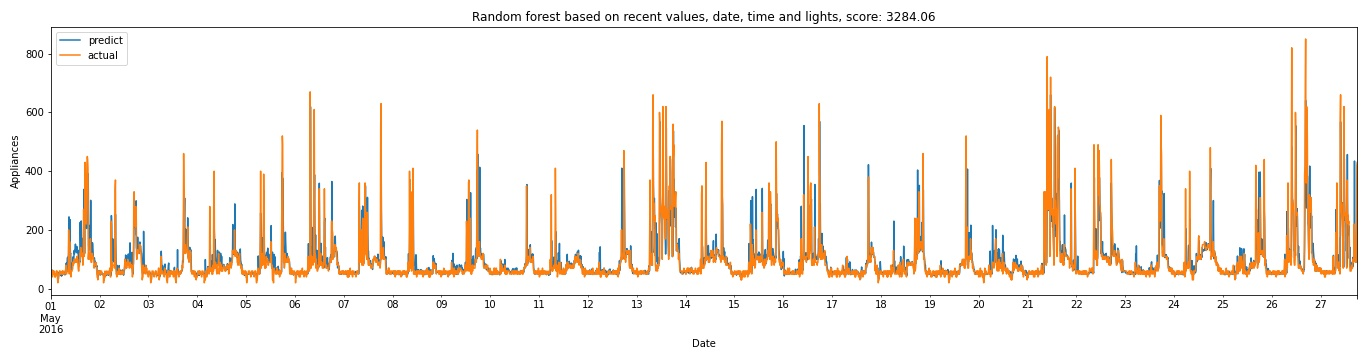

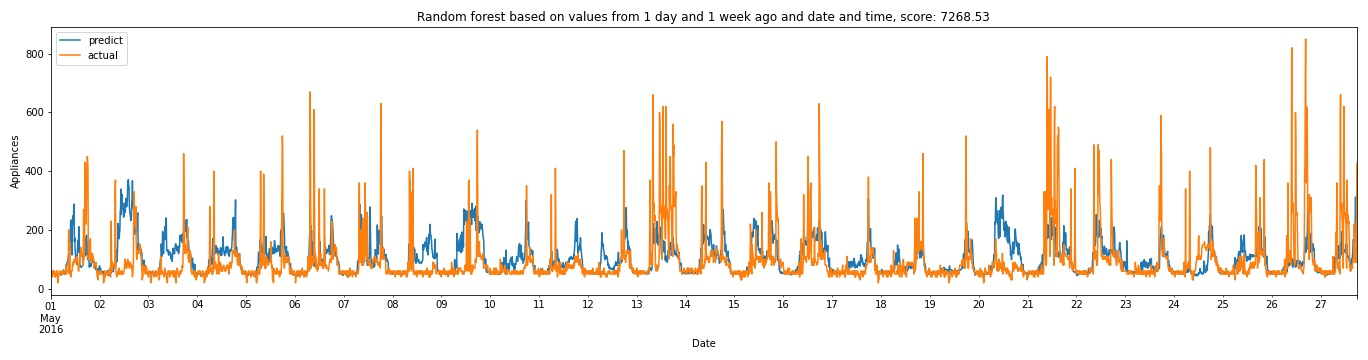

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

<Figure size 1368x360 with 0 Axes>

In [ ]:
from enum import Flag, auto

from sklearn.ensemble import RandomForestRegressor

class FeatureMode(Flag):
    recent = auto()
    datetime = auto()
    allexo = auto()
    lights = auto()
    oneday_oneweek = auto()
    recent_datetime = recent | datetime
    recent_datetime_allexo = recent_datetime | allexo
    recent_datetime_lights = recent_datetime | lights
    oneday_oneweek_datetime = oneday_oneweek | datetime

for feature_mode, mode_description in (
        (FeatureMode.recent, 'recent values'),
        (FeatureMode.datetime, 'date and time'),
        (FeatureMode.recent_datetime, 'recent values and date and time'),
        (FeatureMode.recent_datetime_allexo, 'recent values, date, time and exogenous variables'),
        (FeatureMode.recent_datetime_lights, 'recent values, date, time and lights'),
        (FeatureMode.oneday_oneweek_datetime, 'values from 1 day and 1 week ago and date and time')):
    if feature_mode & FeatureMode.allexo:
        features = ['lights', 'T1', 'RH_1', 'Press_mm_hg', 'Windspeed', 'Visibility', 'rv1']
    elif feature_mode & FeatureMode.lights:
        features = ['lights']
    else:
        features = []

    df_tmp = df[['date', 'Appliances'] + features].copy()

    for feature in features:
        df_tmp[feature] = df_tmp[feature].shift(1)

    if feature_mode & FeatureMode.recent:
        for i in range(1, 10):
            df_tmp[f'Previous{i}'] = df_tmp['Appliances'].shift(i)

    if feature_mode & FeatureMode.oneday_oneweek:
        for i in range(6*24, 6*24 + 10):
            df_tmp[f'Previous{i}'] = df_tmp['Appliances'].shift(i)
        for i in range(6*24*7, 6*24*7 + 10):
            df_tmp[f'Previous{i}'] = df_tmp['Appliances'].shift(i)

    if feature_mode & FeatureMode.datetime:
        df_tmp['minute'] = df_tmp['date'].dt.minute
        df_tmp['hour'] = df_tmp['date'].dt.hour
        df_tmp['weekday'] = df_tmp['date'].dt.weekday
        df_tmp['monthday'] = df_tmp['date'].dt.day
        # df_tmp['month'] = df_tmp['date'].dt.month

    df_tmp = df_tmp.set_index('date').dropna()

    mask_train = df_tmp.index < pd.to_datetime('2016-05-01')

    X_train = df_tmp[mask_train]
    y_train = X_train['Appliances']
    X_train = X_train.drop('Appliances', axis=1)
    X_test = df_tmp[~mask_train]
    y_test = X_test['Appliances']
    X_test = X_test.drop('Appliances', axis=1)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    if feature_mode is FeatureMode.recent:
        plot_title = "Baseline: prediction equals previous value"
        result = pd.DataFrame({'predict': X_test['Previous1'], 'actual': y_test})
        score = ((result['predict'] - result['actual'])**2).mean()
        result.plot(xlabel="Date", ylabel="Appliances", figsize=(19, 5), title=plot_title + f", score: {score:.2f}")
        plt.tight_layout()
        display_plot_as_image()

    plot_title = "Random forest based on " + mode_description
    result = pd.DataFrame({'predict': y_predict, 'actual': y_test})
    score = ((result['predict'] - result['actual'])**2).mean()
    result.plot(xlabel="Date", ylabel="Appliances", figsize=(19, 5), title=plot_title + f", score: {score:.2f}")
    plt.tight_layout()
    display_plot_as_image()